In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import pickle
import os
import math
from collections import Counter
from num2words import num2words
import numpy as np
import sklearn.metrics.pairwise
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
ps = PorterStemmer()

In [2]:
def removeStopWords(words):
    filteredWords = []
    stop_words=stopwords.words('english')
    for word in words:
        if word not in stop_words:
            word = ps.stem(word)
            filteredWords.append(word)
    return filteredWords

def loadFromPickle(pickleFile):
	file = open(pickleFile,'rb')
	pickleData = pickle.load(file)
	file.close()
	return pickleData

In [3]:
def saveInPickle(data, pickleFile):
	file = open(pickleFile,"wb")
	pickle.dump(data,file)
	file.close()
    
def getAllFoldersPath():
	filesList=[]
	path="stories"
	filesList =  [x[0] for x in os.walk(path)]

	return filesList[1:]

def getNumWordFixed(fileContent):
    result = []
#     fileContent = fileContent.split()
    for word in fileContent:
            if(word.isnumeric()):
                word = num2words(word)
                tokenizer=RegexpTokenizer(r'([A-Za-z0-9]+)')
                tokensList=tokenizer.tokenize(word)
#                 print(tokensList)
                result+=tokensList
            else:
                result.append(word)
                
    return result

In [4]:
def getAllTokens(foldersPathList):
    count=0
    docIdsSet = []
    docWordsDictionary = {}
    vocab = []
    for folderCount, path in enumerate(foldersPathList):
        for r, d, f in os.walk(path):
            for file in f:
                filePath = os.path.join(r, file)
                fileReference = open(filePath, "r", encoding = "ISO-8859-1")
                fileContent=fileReference.read()
                fileContent = fileContent.lower()                
                tokenizer=RegexpTokenizer(r'([A-Za-z0-9]+)')
                tokensList=tokenizer.tokenize(fileContent)
                fileContent = getNumWordFixed(tokensList)
                filteredWords = removeStopWords(fileContent)
                docId = int(file)
                docId = docId*100+folderCount
#                 folderMap[folderCount] = r
                docIdsSet.append(docId)
#                 print(filteredWords)
                count+=len(filteredWords)
                docWordsDictionary[docId] = filteredWords
                vocab+=filteredWords
#                 print(docWordsDictionary)
    return docWordsDictionary, list(set(vocab))

In [5]:
foldersPathList = ['20_newsgroups/comp.graphics', '20_newsgroups/sci.med',
'20_newsgroups/talk.politics.misc', '20_newsgroups/rec.sport.hockey', '20_newsgroups/sci.space']

In [18]:
docWords, vocab = getAllTokens(foldersPathList)

In [25]:
len(docWords)

5000

In [21]:
saveInPickle(docWords, "docWords")
saveInPickle(vocab, "vocab")

In [23]:
docWords = loadFromPickle("docWords")
vocab = loadFromPickle("vocab")

In [6]:
def getTfValues(docWords):
    tf = {}
    count = 0
    for doc in docWords:
        for word in docWords[doc]:
            if word not in tf:
                tf[word] = {}
            if doc not in tf[word]:
                tf[word][doc] = 0
            tf[word][doc]+=1
    return tf

def getIdfVal(idfCount):
    N= len(docWords)
#     print(N, idfCount)
    return math.log(N/(1+idfCount), 10)

def tfVariant(freq):
    return 1 + math.log(freq, 10)

def getIdf(tfValues):
    idf = {}
    for word in tfValues:
        nt = len(tfValues[word])
        idf[word] = getIdfVal(nt)
    return idf

In [27]:
tfValues = getTfValues(docWords)
saveInPickle(tfValues, "tfValues")

In [31]:
idf = getIdf(tfValues)
saveInPickle(idf, "idf")

In [32]:
len(idf)

42077

In [11]:
def preprocesQuery(query):
    query = query.lower()
    tokenizer=RegexpTokenizer(r'([A-Za-z0-9]+)')
    tokensList=tokenizer.tokenize(query)
    fileContent = getNumWordFixed(tokensList)
    filteredWords = removeStopWords(fileContent)
    return filteredWords

def checkOutOfVocab(query):
    flag = 0
    for word in query:
        if word not in vocab:
            flag = 1
            print("query word :", word,"is out of vocab")
            break
    return flag

In [7]:
def generateQueryVector(query):
    queryVector = []
    queryUnique = query     
    for word in queryUnique:
        if(word in vocab):
            tf = 1 + math.log(query.count(word), 10)
            tfIdf = tf*idf[word]    
        else:
            tfIdf = 0
        queryVector.append(tfIdf)
    return np.array(queryVector)

def generateDocVector(query, doc):
    docVector = []
    for word in query:
        sim = 0
        if(doc in tfValues[word]):
            tfIdf = tfValues[word][doc]*idf[word]
        else:
            tfIdf = 0
        docVector.append(tfIdf)    
    return np.array(docVector)

def cosineSimilarity(queryVector, docVector):
    score = 0
    qMod = dMod = 0
    for i in range(len(queryVector)):
        score+=queryVector[i]*docVector[i]
        qMod+=queryVector[i]*queryVector[i]
        dMod+=docVector[i]*docVector[i]
    if(qMod==0 or dMod==0):
        score = 0
    else:
        qMod = math.sqrt(qMod)
        dMod = math.sqrt(dMod)
        score = score/(qMod*dMod)
    return score

In [8]:
def calculateNetScore(queryVector):
    docsList = docWords.keys()
    scoreDocList = []
    docVectors = []
    for doc in docsList:
        docVector = generateDocVector(queryUnique, doc)
        sim = cosineSimilarity(queryVector, docVector)
        scoreDocList.append((doc, sim))
        
    return scoreDocList

def getResults(scoreDocList,markedDocs,  k):
    docList = []
    count = 1
    scoreDocList.sort(key = lambda x: x[1], reverse = True)
    for item in scoreDocList:
        docList.append(item[0])
        docId = item[0]
        folder = int(docId%100)
        docId = int(docId/100)
        if item[0] in markedDocs:
            print("*", str(count)+".", foldersPathList[folder], docId)
        else:
            print(" ",str(count)+".", foldersPathList[folder], docId)
        count+=1
        if(count==k+1):
            break
    return docList

In [99]:
def markDocuments(docList):
    print("\n Mark relevant docs in the above result--- enter comma separated document serial numbers from above results")
    print("\n eg. 1,7,24,35,39,47,48 ")
    relevantDocs = []  
    markedDocs = input()
    markedDocs = markedDocs.split(",")
    for i in range(len(markedDocs)):
        relevantDocs.append(docList[int(markedDocs[i])-1]) 
    
    print("\nMarked Documents\n")

    for item in relevantDocs:
        docId = item
        folder = int(docId%100)
        docId = int(docId/100)
        print(foldersPathList[folder], docId)
    print("\n\n")
    return relevantDocs

def refineQuery(queryVector,docList, markedDocs):
    alpha = 1
    beta = 0.75
    gamma = 0.25
    relevantVector = np.zeros(shape=(len(queryVector, )))
    nonRelVector = np.zeros(shape=(len(queryVector,)))
    
    for doc in docList:
        docVector = generateDocVector(queryUnique, doc)
        if doc in markedDocs:
            relevantVector = np.add(relevantVector, np.array(docVector))
        else:
            nonRelVector = np.add(nonRelVector, np.array(docVector))
    
    relevantVector/=len(markedDocs)
    nonRelVector/=(len(docList) - len(markedDocs))
    
    queryVector = alpha*queryVector + beta*relevantVector - gamma*nonRelVector
#     print(queryVector)
    queryVector = queryVector.clip(min=0)

    return queryVector

In [10]:
#######--------------------loading data from pickle-----------------------------------------------------
docWords = loadFromPickle("docWords")
vocab = loadFromPickle("vocab")
idf = loadFromPickle("idf")
tfValues = loadFromPickle("tfValues")

In [2]:
###########---------------query input ----------------
### multiple queries can be input at once or single as well. The values of K and n(iterations) will
### remain same for all queries . Best of luck!!!

nq = int(input("Enter the number of queries you wish to retrieve results for : "))
queries = []
groundTruth = []
for i in range(nq):
    query = input("enter the query"+str(i+1)+" : ")
    query = preprocesQuery(query)
    if(checkOutOfVocab(query)==1):
        print("Aaah!! This query contains word that are out of vocab. Try again!")
        pass
    queries.append(query)
    truth = input("enter the ground truth folder for this query : (eg. sci.med , sci.space, comp.graphics etc)")
    groundTruth.append(truth)

k = int(input("enter the value of k for this query:"))
n = int(input("enter the number of iterations"))
autoTrue = int(input("Enter 1 for automating p% of Top k docs marking process , Enter 2 for manual doc marking"))
if(autoTrue==1):
    p = int(input("Enter the value of p (for marking p% of top K docs)"))

Enter the number of queries you wish to retrieve results for : 1
enter the query1 : Pretty good opinions on biochemistry machines


NameError: name 'preprocesQuery' is not defined

In [179]:
####### check pre-processed queries before proceeding
queries

[['pretti', 'good', 'opinion', 'biochemistri', 'machin']]

In [24]:
##### run ; for bold text
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    

In [180]:
def getQueryPrecisionRecall(resultDoc, groundTruthFolder):
    truthPath = '20_newsgroups/'+groundTruthFolder
    precisionk = []
    recallk = []
    relCount = 0
    nonRelCount = 0
    total = 0
    meanap=0
    for doc in resultDoc:
        folderId = doc%100
        
        if(foldersPathList[folderId]==truthPath):
            relCount+=1
        total+=1
        precision = relCount/total
        if(foldersPathList[folderId]==truthPath):
            meanap+=precision
        recall = relCount/1000
        precisionk.append(precision)
        recallk.append(recall)

    evalDict = {"precision":precisionk, "recall":recallk, "map":meanap/k}
    return evalDict
            


In [195]:
precisions = []
recalls = []
maps = []
queryVectors = []
tsne = {} 

In [ ]:
####------- query relevance feedback --------------------------------- 

for i in range(nq):
    printmd("\n**----------------------QUERY"+str(i+1)+"-------------------------------**\n")
    queryUnique = list(set(queries[i])) 
    queryVector = generateQueryVector(queryUnique)
    markedDocs = []
    qVectors = []
    precision = []
    recall = []
    meanap = []
    tsne[i] = [queryUnique]
    scoreDocList = calculateNetScore(queryVector)
    resultDoc = getResults(scoreDocList, markedDocs, k)
    tsne[i].append((queryVector,resultDoc))
    
    evalDict = getQueryPrecisionRecall(resultDoc, groundTruth[i])
    precision.append(evalDict["precision"])
    recall.append(evalDict["recall"])
    meanap.append(evalDict["map"])
    
    for j in range(n):
        printmd("\n\n\n**---------------QUERY"+str(i+1)+" : Iteration"+str(j+1)+" begins------------------**\n")
        markedDocs = markDocuments(resultDoc)
        queryVector = refineQuery(queryVector, resultDoc, markedDocs)
        qVectors.append(queryVector)
        scoreDocList = calculateNetScore(queryVector)
        printmd("\n**---------------Results------------------**\n")
        resultDoc = getResults(scoreDocList, markedDocs, k)
        evalDict = getQueryPrecisionRecall(resultDoc, groundTruth[i])
        precision.append(evalDict["precision"])
        recall.append(evalDict["recall"])
        meanap.append(evalDict["map"])
        tsne[i].append((queryVector,resultDoc))

    topDocVector = generateDocVector(queryUnique, resultDoc[0])
    qVectors.append(topDocVector)
    precisions.append(precision)
    recalls.append(recall)
    maps.append(meanap)
    queryVectors.append(qVectors)
    
    if(i<=n-2 and nq>1):
        text = input("Press Enter to continue for next query")  # or raw_input in python2




**----------------------QUERY1-------------------------------**


  1. 20_newsgroups/comp.graphics 38523
  2. 20_newsgroups/sci.med 59488
  3. 20_newsgroups/sci.med 59207
  4. 20_newsgroups/sci.med 59233
  5. 20_newsgroups/sci.med 59183
  6. 20_newsgroups/sci.med 59165
  7. 20_newsgroups/sci.med 59632
  8. 20_newsgroups/sci.med 59400
  9. 20_newsgroups/sci.med 59323
  10. 20_newsgroups/sci.med 59548
  11. 20_newsgroups/sci.med 59116
  12. 20_newsgroups/sci.med 58872
  13. 20_newsgroups/sci.med 59602
  14. 20_newsgroups/sci.med 58082
  15. 20_newsgroups/sci.med 58987
  16. 20_newsgroups/comp.graphics 38597
  17. 20_newsgroups/sci.med 59504
  18. 20_newsgroups/sci.med 59518
  19. 20_newsgroups/sci.med 58813
  20. 20_newsgroups/sci.med 59154
  21. 20_newsgroups/comp.graphics 38669
  22. 20_newsgroups/talk.politics.misc 178653
  23. 20_newsgroups/comp.graphics 37922
  24. 20_newsgroups/talk.politics.misc 178493
  25. 20_newsgroups/talk.politics.misc 176953
  26. 20_newsgroups/sci.med 59393
  27. 20_newsgroups/comp.graphics 38257
  28. 20_newsgroups/sci.m




**---------------QUERY1 : Iteration1 begins------------------**



 Mark relevant docs in the above result--- enter comma separated document serial numbers from above results

 eg. 1,3,4,5,6,7 
95

Marked Documents

20_newsgroups/sci.med 59308






**---------------Results------------------**


  1. 20_newsgroups/sci.med 59154
  2. 20_newsgroups/comp.graphics 38523
  3. 20_newsgroups/sci.med 59393
  4. 20_newsgroups/sci.med 58953
  5. 20_newsgroups/comp.graphics 38853
  6. 20_newsgroups/comp.graphics 38376
  7. 20_newsgroups/sci.med 58568
  8. 20_newsgroups/comp.graphics 39078
  9. 20_newsgroups/comp.graphics 38403
  10. 20_newsgroups/comp.graphics 39638
  11. 20_newsgroups/comp.graphics 38774
  12. 20_newsgroups/comp.graphics 38861
  13. 20_newsgroups/comp.graphics 38959
  14. 20_newsgroups/comp.graphics 38392
  15. 20_newsgroups/sci.med 59301
  16. 20_newsgroups/comp.graphics 38852
  17. 20_newsgroups/comp.graphics 38375
  18. 20_newsgroups/talk.politics.misc 178894
* 19. 20_newsgroups/sci.med 59308
  20. 20_newsgroups/sci.space 61435
  21. 20_newsgroups/comp.graphics 38304
  22. 20_newsgroups/comp.graphics 38778
  23. 20_newsgroups/comp.graphics 38851
  24. 20_newsgroups/comp.graphics 38377
  25. 20_newsgroups/talk.politics.misc 176936
  26. 20_newsgroups/sci.med 59071
  2




**---------------QUERY1 : Iteration2 begins------------------**



 Mark relevant docs in the above result--- enter comma separated document serial numbers from above results

 eg. 1,3,4,5,6,7 
94

Marked Documents

20_newsgroups/sci.med 58956






**---------------Results------------------**


  1. 20_newsgroups/sci.med 59154
  2. 20_newsgroups/comp.graphics 38523
  3. 20_newsgroups/sci.med 58953
  4. 20_newsgroups/sci.med 59393
  5. 20_newsgroups/comp.graphics 38853
  6. 20_newsgroups/comp.graphics 38376
  7. 20_newsgroups/sci.med 58568
  8. 20_newsgroups/sci.med 59301
  9. 20_newsgroups/comp.graphics 38774
  10. 20_newsgroups/comp.graphics 38861
  11. 20_newsgroups/comp.graphics 38959
  12. 20_newsgroups/comp.graphics 38392
  13. 20_newsgroups/comp.graphics 38304
  14. 20_newsgroups/sci.med 59308
  15. 20_newsgroups/sci.space 61435
  16. 20_newsgroups/comp.graphics 38851
  17. 20_newsgroups/comp.graphics 38377
  18. 20_newsgroups/talk.politics.misc 176936
  19. 20_newsgroups/sci.space 61253
  20. 20_newsgroups/comp.graphics 38852
  21. 20_newsgroups/comp.graphics 38375
  22. 20_newsgroups/talk.politics.misc 178894
  23. 20_newsgroups/comp.graphics 39078
  24. 20_newsgroups/comp.graphics 38403
  25. 20_newsgroups/comp.graphics 39638
  26. 20_newsgroups/sci.med 59071
  27. 2




**---------------QUERY1 : Iteration3 begins------------------**



 Mark relevant docs in the above result--- enter comma separated document serial numbers from above results

 eg. 1,3,4,5,6,7 


In [191]:
##### plotting Precision, recall
def plotPRcurve(precisions, recalls):
    for i in range(nq):
        printmd("\n**---------------QUERY"+str(i+1)+"------------------**\n")
        for j in range(n):
            printmd("\n**---------------Iteration"+str(j+1)+"------------------**\n")
            plt.figure()
            plt.plot(precisions[i][j], recalls[i][j])
            # Show/save figure as desired.
            plt.show()
            plt.pause(0.05)
        print("\n")


**---------------QUERY1------------------**



**---------------Iteration1------------------**


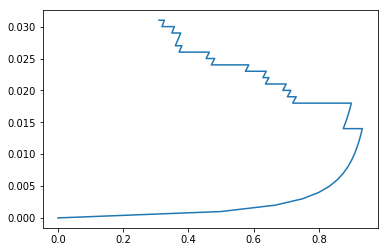


**---------------Iteration2------------------**


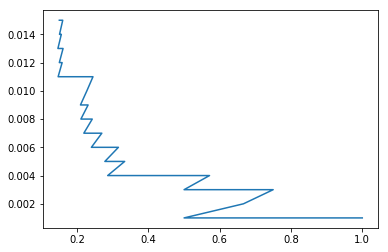


**---------------Iteration3------------------**


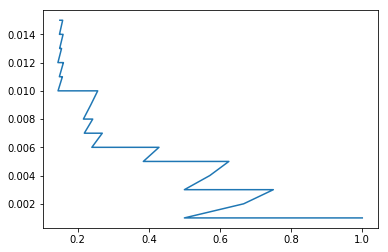


**---------------Iteration4------------------**


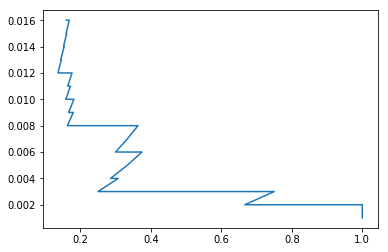

In [193]:
plotPRcurve(precisions, recalls)

In [194]:
###### MAP values----------
for j in range(n):
    mapVal = 0
    printmd("\n**---------------Iteration "+str(j+1)+"------------------**\n")
    for i in range(nq):
        mapVal+=maps[i][j]
    print(mapVal/nq)


**---------------Iteration 1------------------**


0.22017957901140706



**---------------Iteration 2------------------**


0.05484878046897459



**---------------Iteration 3------------------**


0.05835464447832869



**---------------Iteration 4------------------**


0.05802784052837528


In [133]:
len(tsne[0])

6

In [186]:
#######----------plotting 2D TSNE curve for query vectors --------------------
def processTsneData(queryUnique, resultDocs, groundTruthIndex):
    relVectors = nonRelVectors = []
    truthPath = '20_newsgroups/'+groundTruth[groundTruthIndex]
    for doc in resultDoc:
        folderId = doc%100
        vector = generateDocVector(queryUnique, doc)
        if(foldersPathList[folderId]==truthPath):
            relVectors.append(vector)
        else:
            nonRelVectors.append(vector)
    return relVectors, nonRelVectors

['biochemistri', 'pretti', 'machin', 'good', 'opinion']



---------------**QUERY 1**------------------


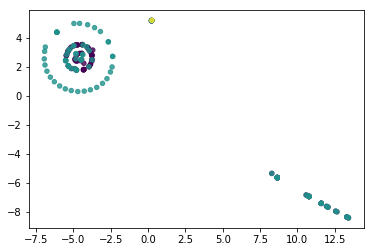

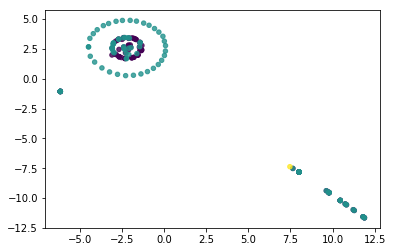

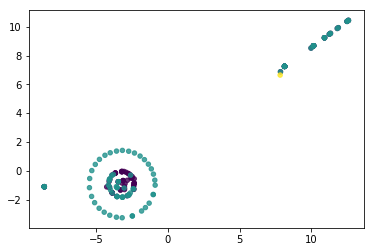

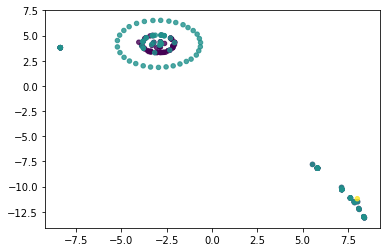

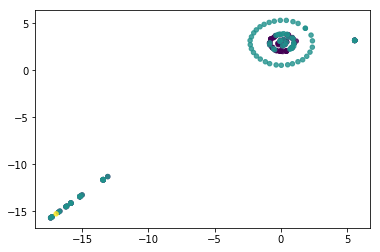

In [189]:
######-----------2D TSNE CURVE FOR QUERY VECTORS
count = 0
for key in tsne:
    queryUnique = tsne[key][0]
    print(queryUnique)
    printmd("\n---------------**QUERY "+str(key+1)+"**------------------\n")
    for i,item in enumerate(tsne[key][1:]):
        queryVector = []
        labels = []
        vectors = []
        queryVector = item[0]
#         queryVector.append(item[0])
        relVectors, nonRelVectors = processTsneData(queryUnique, item[1], key)
        for i,v in enumerate(relVectors):
            vectors.append(relVectors[i])
            labels.append(3)
        for i,v in enumerate(nonRelVectors):
            vectors.append(nonRelVectors[i])
            labels.append(4)
       
        labels.append(5)

#         vectors.append(relVectors)
#         vectors.append(nonRelVectors)
        vectors.append(queryVector)
        
        tsneData = TSNE(n_components=2).fit_transform(vectors) 
#         relTsne = TSNE(n_components=2).fit_transform(relVectors)
#         nonRelTsne = TSNE(n_components=2).fit_transform(nonRelVectors)
#         queryTsne = TSNE(n_components=2).fit_transform(queryVector)
#         print(queryTsne.shape)
        plt.figure()
#         plt.scatter(queryTsne[:,0], queryTsne[:,1], color = 'r', s=10)
#         plt.scatter(relTsne[:,0], relTsne[:,1], color = 'g', s=10)
#         plt.scatter(nonRelTsne[:,0], nonRelTsne[:,1], color = 'b', s=10)
        plt.scatter(tsneData[:,0], tsneData[:,1], c = labels, s=20, alpha=0.8, label="Violet-NR, blue -R")
        plt.show()
       